## 1. Imports


In [107]:
from scripts.visualization_utils import impact_bar_plots
from scripts.evaluation_utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [108]:
data_path = '../data/results/test_1_balanced_seed42/'
#data_path = '../data/results/june1/'
folders= ['dt','gnb','lgr','gbt']
#folders = ['dt']

## 2. DI_plots and CSV

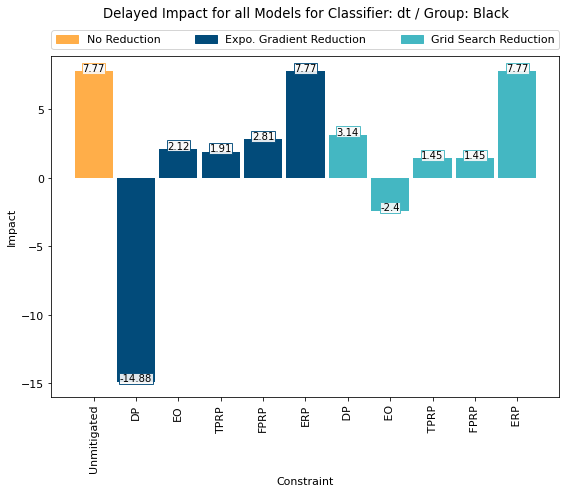

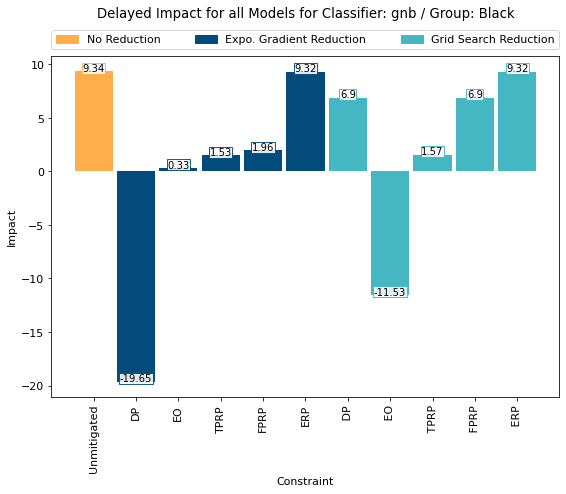

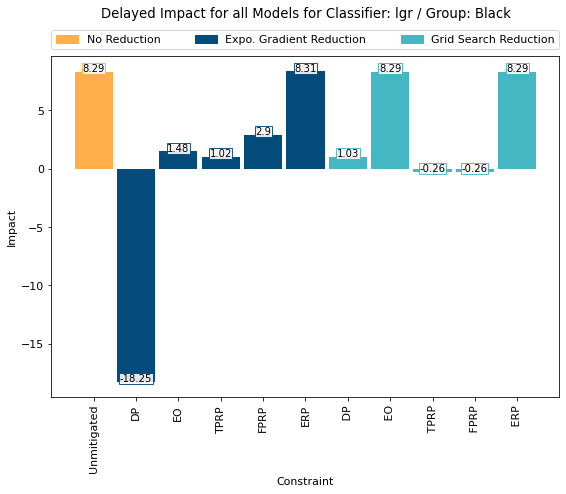

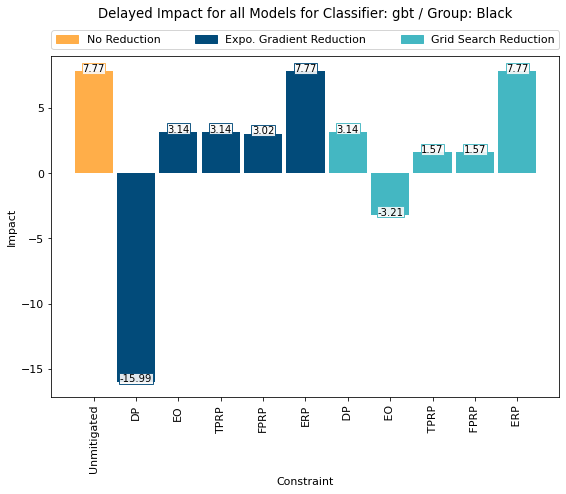

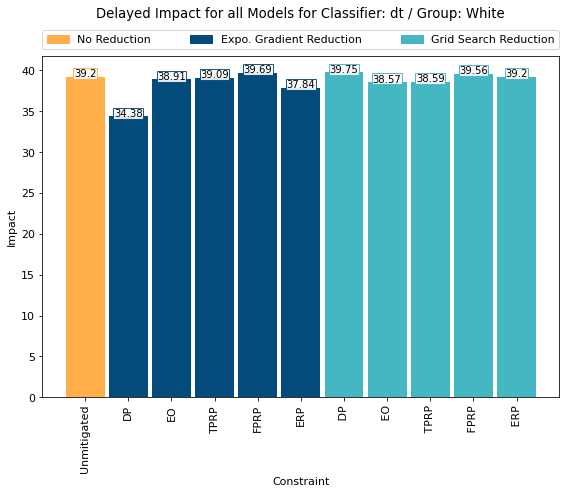

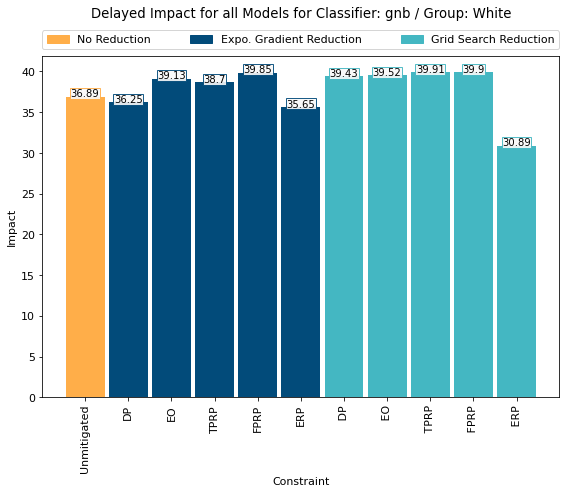

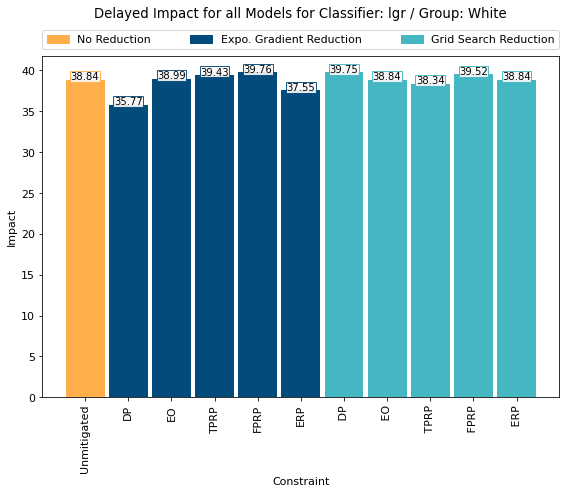

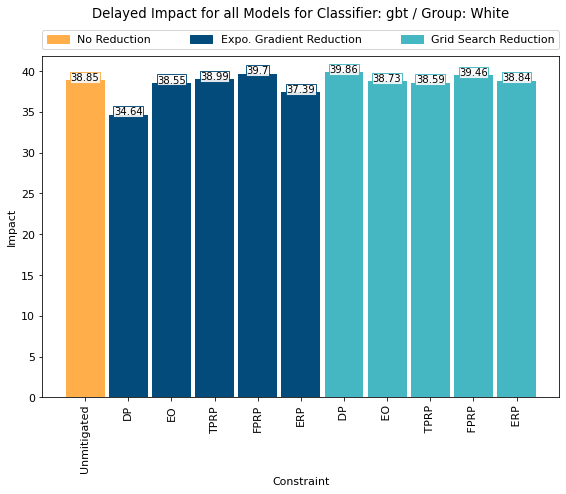

In [93]:
impact_bar_plots(data_path,'Black',folders)
impact_bar_plots(data_path,'White',folders)

In [94]:
impact_csvs(data_path,'Black', folders= ['dt','gnb','lgr','gbt'])
impact_csvs(data_path,'White', folders= ['dt','gnb','lgr','gbt'])

Group:  Black 
 DataFrame: 
              EG+DT  EG+GNB  EG+LGR  EG+GBT  GS+DT  GS+GNB  GS+LGR  GS+GBT
Constraint                                                               
Unmitigated   7.77    9.34    8.29    7.77   7.77    9.34    8.29    7.77
DP          -14.88  -19.65  -18.25  -15.99   3.14    6.90    1.03    3.14
EO            2.12    0.33    1.48    3.14  -2.40  -11.53    8.29   -3.21
EOO           1.91    1.53    1.02    3.14   1.45    1.57   -0.26    1.57
FPER          2.81    1.96    2.90    3.02   1.45    6.90   -0.26    1.57
ERP           7.77    9.32    8.31    7.77   7.77    9.32    8.29    7.77
A
B
Group:  White 
 DataFrame: 
              EG+DT  EG+GNB  EG+LGR  EG+GBT  GS+DT  GS+GNB  GS+LGR  GS+GBT
Constraint                                                               
Unmitigated  39.20   36.89   38.84   38.85  39.20   36.89   38.84   38.85
DP           34.38   36.25   35.77   34.64  39.75   39.43   39.75   39.86
EO           38.91   39.13   38.99   38.55  38.57 

C:\Users\HaRi\Documents\GitHub\delayedimpact-daadww\notebooks\..\scripts\evaluation_utils.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eg['Constraint'] = ['Unmitigated', 'DP', 'EO', 'EOO','FPER','ERP']
C:\Users\HaRi\Documents\GitHub\delayedimpact-daadww\notebooks\..\scripts\evaluation_utils.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eg['Constraint'] = ['Unmitigated', 'DP', 'EO', 'EOO','FPER','ERP']


## 3. FP/TP/TN/FN Ratios

In [95]:
types_ratios_csv(data_path,folders)

dt
Classifier:  dt 
 DataFrame: 
 ID        egdpB     egdpW     egeoB     egeoW    egerpB    egerpW   egfprpB  \
Value                                                                         
FN     0.030458  0.207765  0.053267  0.110176  0.088421  0.062806  0.055213   
FP     0.247082  0.018020  0.122367  0.036968  0.067087  0.068835  0.116799   
TN     0.417751  0.219756  0.542466  0.200808  0.597746  0.168941  0.548034   
TP     0.304710  0.554459  0.281900  0.652047  0.246746  0.699417  0.279954   

ID      egfprpW   egtprpB   egtprpW     gsdpB     gsdpW     gseoB     gseoW  \
Value                                                                         
FN     0.089837  0.052127  0.110574  0.056286  0.081754  0.044210  0.126209   
FP     0.041606  0.124312  0.035246  0.114048  0.045250  0.156984  0.030873   
TN     0.196171  0.540521  0.202531  0.550785  0.192527  0.507849  0.206903   
TP     0.672386  0.283040  0.651650  0.278881  0.680469  0.290957  0.636014   

ID       gserpB 

## 4. Score Distributions

Loading All Scores and splitting it into multiple dataframes

In [96]:
classifier_dfs = {}
dfs_b = {}
dfs_w = {}
dfs_eg = {}
dfs_gs = {}
for f in folders:
    path = f'{data_path}{f}/{f}_all_scores.csv'
    df = pd.read_csv(path)
    df = df.reset_index(drop=True)
    

    df_black = df.filter(like='B')
    df_white = df.filter(like='W')
    df_eg = pd.concat([df.iloc[:,:4],df.filter(like='eg')],axis=1)
    df_gs = pd.concat([df.iloc[:,:4],df.filter(like='gs')],axis=1)
    
    classifier_dfs[f] = df
    dfs_b[f] = df_black
    dfs_w[f] = df_white
    dfs_eg[f] = df_eg
    dfs_gs[f] = df_gs
print(dfs_b['gbt'])

       testB  unmitB  egdpB  egeoB  egtprpB  egfprpB  egerpB  gsdpB  gseoB  \
0      763.0   838.0  838.0  838.0    838.0    838.0   838.0  838.0  838.0   
1      710.0   785.0  785.0  785.0    785.0    785.0   785.0  785.0  785.0   
2      390.0   390.0  390.0  390.0    390.0    390.0   390.0  390.0  390.0   
3      662.0   737.0  737.0  737.0    737.0    737.0   737.0  737.0  737.0   
4      475.0   475.0  475.0  475.0    475.0    475.0   475.0  475.0  475.0   
...      ...     ...    ...    ...      ...      ...     ...    ...    ...   
15089    NaN     NaN    NaN    NaN      NaN      NaN     NaN    NaN    NaN   
15090    NaN     NaN    NaN    NaN      NaN      NaN     NaN    NaN    NaN   
15091    NaN     NaN    NaN    NaN      NaN      NaN     NaN    NaN    NaN   
15092    NaN     NaN    NaN    NaN      NaN      NaN     NaN    NaN    NaN   
15093    NaN     NaN    NaN    NaN      NaN      NaN     NaN    NaN    NaN   

       gstprpB  gsfprpB  gserpB  
0        838.0    838.0   838

Checking if normal distributions:

if p < 0.001 (or < 0.0005) then the distribution is significantly different from a normal distribution

In [101]:
for c,df in classifier_dfs.items():
    print('Classifier:',c)
    for col in df:
        data=df[col].dropna(axis=0)
        _,p = stats.kstest(data, "norm")
        if p > 0.01:
            print(col,',p:',p)
    print('Check for norm Distributions done')

Classifier: dt
Check for norm Distributions done
Classifier: gnb
Check for norm Distributions done
Classifier: lgr
Check for norm Distributions done
Classifier: gbt
Check for norm Distributions done


Mann whitney u test:

“a two-sample rank test for the difference between two population medians . . . It assumes that the data are independent random samples from two populations that have the same shape.”

#### Variance of Distributions EG vs. GS
if p < 0.001 (or < 0.05) then the distributions are significantly different from each other

In [102]:
p_vals = pd.DataFrame(data={'Constraints': []})
for (c1,df_eg),(c2,df_gs) in zip(dfs_eg.items(),dfs_gs.items()):
    col_vals = []
    idx = []
    for col_eg,col_gs in zip(df_eg,df_gs):
        idx.append(col_eg[2:])
        data_eg=df_eg[col_eg].dropna(axis=0)
        data_gs=df_gs[col_gs].dropna(axis=0)
        _,p = stats.mannwhitneyu(data_eg, data_gs)
        if p< 0.05:
            col_vals.append('sig_diff')
        else:
            col_vals.append('')
    p_vals[c1] = col_vals
p_vals['Constraints'] = idx
p_vals = p_vals.set_index('Constraints')
p_vals = p_vals.round(decimals=3)
print(p_vals)
p_vals.to_csv(f'{data_path}significanz_eg_gs.csv')

                   dt       gnb       lgr       gbt
Constraints                                        
stB                                                
stW                                                
mitB                                               
mitW                                               
dpB          sig_diff  sig_diff  sig_diff  sig_diff
dpW                                                
eoB          sig_diff  sig_diff  sig_diff  sig_diff
eoW                                                
tprpB                                      sig_diff
tprpW                                              
fprpB                  sig_diff  sig_diff          
fprpW                                              
erpB                                               
erpW                                               


#### Variance of Distributions unmitigated v Mitigated for each race

if p < 0.001 (or < 0.0005) then the distributions are significantly different from each other

In [103]:
p_vals = pd.DataFrame(data={'Constraints': []})
print('Black:')
for c,df in dfs_b.items():
    col_vals = []
    idx = []
    data_unmiti = df['unmitB'].dropna(axis=0)
    for col in df:
        idx.append(col[:-1])
        data_miti=df[col].dropna(axis=0)
        _,p = stats.mannwhitneyu(data_unmiti, data_miti)
        if p< 0.05:
            col_vals.append('sig_diff')
        else:
            col_vals.append('')
    p_vals[c] = col_vals
p_vals['Constraints'] = idx
p_vals = p_vals.set_index('Constraints')
p_vals = p_vals.round(decimals=3)
print(p_vals)
p_vals.to_csv(f'{data_path}significanz_un_vs_miti_b.csv')


p_vals = pd.DataFrame(data={'Constraints': []})        
print('White:')        
for c,df in dfs_w.items():
    col_vals = []
    idx = []
    data_unmiti = df['unmitW'].dropna(axis=0)
    for col in df:
        idx.append(col[:-1])
        data_miti=df[col].dropna(axis=0)
        _,p = stats.mannwhitneyu(data_unmiti, data_miti)
        if p< 0.05:
            col_vals.append('sig_diff')
        else:
            col_vals.append('')
    p_vals[c] = col_vals
p_vals['Constraints'] = idx
p_vals = p_vals.set_index('Constraints')
p_vals = p_vals.round(decimals=3)
print(p_vals)
p_vals.to_csv(f'{data_path}significanz_un_vs_miti_w.csv')


Black:
                   dt       gnb       lgr       gbt
Constraints                                        
test                                               
unmit                                              
egdp         sig_diff  sig_diff  sig_diff  sig_diff
egeo         sig_diff  sig_diff  sig_diff  sig_diff
egtprp       sig_diff  sig_diff  sig_diff  sig_diff
egfprp       sig_diff  sig_diff  sig_diff  sig_diff
egerp                                              
gsdp         sig_diff  sig_diff  sig_diff  sig_diff
gseo         sig_diff  sig_diff            sig_diff
gstprp       sig_diff  sig_diff  sig_diff  sig_diff
gsfprp       sig_diff  sig_diff  sig_diff  sig_diff
gserp                                              
White:
                   dt       gnb       lgr       gbt
Constraints                                        
test         sig_diff  sig_diff  sig_diff  sig_diff
unmit                                              
egdp                                              